/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pickle.py:1710: UserWarning: [20:21:12] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)



--- CodeBERT Classifier Report ---
              precision    recall  f1-score   support

           A       0.33      0.29      0.31        14
           B       0.29      0.15      0.20        13
           C       0.44      0.57      0.50        14
           D       0.36      0.29      0.32        14
           F       0.52      0.79      0.63        14

    accuracy                           0.42        69
   macro avg       0.39      0.42      0.39        69
weighted avg       0.39      0.42      0.39        69


--- Structured XGBoost Regressor Report ---
              precision    recall  f1-score   support

           A       1.00      0.80      0.89         5
           B       0.86      1.00      0.92         6
           C       0.91      0.91      0.91        11
           D       0.83      1.00      0.91         5
           F       1.00      0.67      0.80         3

    accuracy                           0.90        30
   macro avg       0.92      0.88      0.89       

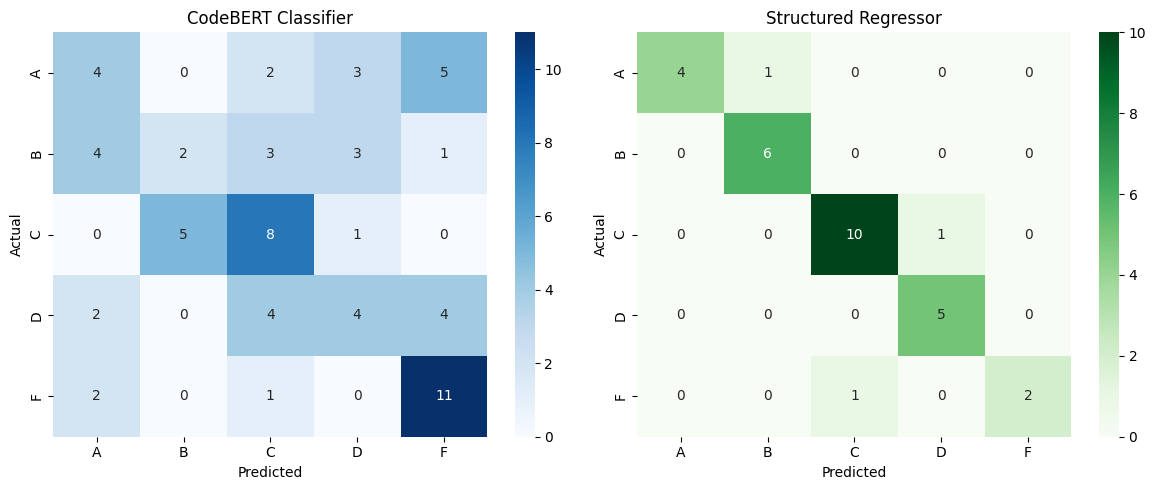

In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import torch
import random
import joblib
from transformers import RobertaTokenizer, RobertaModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from xgboost import XGBRegressor

# 📥 Load and clean data
df = pd.read_csv("../data/processed/updated_data_with_points.csv")
df = df.dropna(subset=["Answer", "Assigned Points"])

# 📝 Combine text fields
df["input_text"] = (
    df["Question"].fillna("NO_QUESTION") + " [SEP] " +
    df["Answer Choices"].fillna("NO_CHOICES") + " [SEP] " +
    df["Answer"].fillna("NO_ANSWER")
)

# 📊 Aggregate by student
student_texts = df.groupby("Student_Id")["input_text"].apply(lambda x: " ".join(x)).reset_index()
student_scores = df.groupby("Student_Id")["Assigned Points"].sum().reset_index()
student_scores.columns = ["Student_Id", "Total_Score"]

# 🎓 Convert scores to grades
def score_to_grade(p, max_score=25.45):
    percent = (p / max_score) * 100
    if percent >= 90:
        return "A"
    elif percent >= 80:
        return "B"
    elif percent >= 70:
        return "C"
    elif percent >= 60:
        return "D"
    else:
        return "F"

student_scores["Grade"] = student_scores["Total_Score"].apply(score_to_grade)
data = pd.merge(student_texts, student_scores, on="Student_Id")

# 🔁 Balance the dataset with duplication and variation
def slightly_modify_text(text):
    words = text.split()
    if len(words) > 5:
        random.shuffle(words)
    return " ".join(words)

def balance_classes(data, label_col="Grade"):
    max_count = data[label_col].value_counts().max()
    balanced_data = []
    for label, group in data.groupby(label_col):
        group = group.copy()
        while len(group) < max_count:
            extra = group.sample(n=min(len(group), max_count - len(group)), replace=True)
            extra["input_text"] = extra["input_text"].apply(slightly_modify_text)
            group = pd.concat([group, extra], ignore_index=True)
        balanced_data.append(group)
    return pd.concat(balanced_data, ignore_index=True)

data = balance_classes(data, label_col="Grade")

# 🔀 Stratified split
y = data["Grade"]
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
X_train_texts, X_test_texts, y_train_enc, y_test_enc = train_test_split(
    data["input_text"], y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 🤖 Load CodeBERT
model_name = "microsoft/codebert-base"
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name)
model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# 🔢 Embedding function
def get_embeddings(texts, batch_size=8):
    all_embeddings = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
            outputs = model(**inputs)
            pooled = outputs.pooler_output.cpu().numpy()
            all_embeddings.append(pooled)
    return np.vstack(all_embeddings)

# 💡 Generate embeddings
X_test_emb = get_embeddings(X_test_texts.tolist())

# 📦 Load saved models
clf = joblib.load("../models/xgboost_grade_model.pkl")
label_encoder = joblib.load("../models/label_encoder.pkl")
xgb_regressor = joblib.load("../models/xgb_model.pkl")

# 🧠 Predict with CodeBERT classifier
y_pred_codebert_enc = clf.predict(X_test_emb)
y_pred_codebert = label_encoder.inverse_transform(y_pred_codebert_enc)
y_test_labels = label_encoder.inverse_transform(y_test_enc)

# 🧠 Predict with XGBoost Regressor (structured features)
student_features_df = pd.read_csv("../data/processed/student_features_with_scores.csv")
student_features_df = student_features_df[student_features_df["Student_Id"].isin(data["Student_Id"])]
X_struct = student_features_df.drop(columns=["Student_Id", "Total Score"])
y_struct = student_features_df["Total Score"]
X_struct = X_struct.fillna(X_struct.mean())
_, X_struct_test, _, y_struct_test = train_test_split(X_struct, y_struct, test_size=0.2, random_state=42)

predicted_scores = xgb_regressor.predict(X_struct_test)

# Convert scores to grades
def convert_scores_to_grades(scores, max_score=25.45):
    return [score_to_grade(p, max_score=max_score) for p in scores]

predicted_struct_grades = convert_scores_to_grades(predicted_scores)
actual_struct_grades = convert_scores_to_grades(y_struct_test)

# 📊 Compare Classification Reports
print("\n--- CodeBERT Classifier Report ---")
print(classification_report(y_test_labels, y_pred_codebert))

print("\n--- Structured XGBoost Regressor Report ---")
print(classification_report(actual_struct_grades, predicted_struct_grades))

# 📉 Confusion Matrix Side-by-Side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
cm1 = confusion_matrix(y_test_labels, y_pred_codebert, labels=label_encoder.classes_)
cm2 = confusion_matrix(actual_struct_grades, predicted_struct_grades, labels=label_encoder.classes_)

sns.heatmap(cm1, annot=True, fmt="d", ax=axes[0], cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[0].set_title("CodeBERT Classifier")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(cm2, annot=True, fmt="d", ax=axes[1], cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
axes[1].set_title("Structured Regressor")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()
